## Predicting if a person has Parkinsons disease (PD) using a database of biomedical voice measurements

### Aim - To investigate which feature pairs best predict if a person has PD or not using a k-nearest neighbour analysis

**Importing all relevant modules that will be needed for the analysis**

In [1]:
from pandas import DataFrame
import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

**Defining the plot_knn function that will be used further on in the analysis**

In [2]:
def plot_knn(model, X, y, resolution=100, ax=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    if X.shape[1] != 2:
        raise ValueError(f"X must have exactly two features to plot, you passed X.shape={X.shape}")
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    x1 = X.iloc[:,0]
    x2 = X.iloc[:,1]
    x1_range = np.linspace(x1.min()*1.1 - x1.max()*0.1, x1.max()*1.1 - x1.min()*0.1, resolution)
    x2_range = np.linspace(x2.min()*1.1 - x2.max()*0.1, x2.max()*1.1 - x2.min()*0.1, resolution)
    grid_x1_values, grid_x2_values = np.meshgrid(x1_range, x2_range)
    x_prime = np.column_stack((grid_x1_values.ravel(), grid_x2_values.ravel()))
    x_prime = pd.DataFrame(x_prime, columns=X.columns)
    y_hat = model.predict(x_prime).reshape(grid_x1_values.shape)

    if ax is None:
        fig, ax = plt.subplots()
    ax.pcolormesh(grid_x1_values, grid_x2_values, y_hat, cmap="Pastel2", alpha=1.0, shading="auto")
    X.plot.scatter(0, 1, c=y, colormap="Dark2", colorbar=False, alpha=0.8, ax=ax)

**Filtering out unneccessary warnings**

In [3]:
import warnings
warnings.filterwarnings("ignore")

**Loading the dataset and visualising it as a dataframe**

In [4]:
df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data")
df

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,...,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,...,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,...,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,...,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


**Visualizing the target response variable that we want to predict as an array**

**Where *0* indicates that the person is healthy, and *1* indicates that the person has PD**

In [5]:
y= df['status']
y

0      1
1      1
2      1
3      1
4      1
      ..
190    0
191    0
192    0
193    0
194    0
Name: status, Length: 195, dtype: int64

**Exploring the data**

In [6]:
#Summarizing our target response
y.value_counts()
print(f'Number of people without PD: {y.value_counts()[0]}')
print(f'Number of people with PD: {y.value_counts()[1]}')

Number of people without PD: 48
Number of people with PD: 147


In [7]:
#Average for each attribute for the two target groups
df.groupby("status").mean()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
status,,,,,,,,,,,,,,,,,,,,,
0,181.937771,223.636750,145.207292,0.003866,0.000023,0.001925,0.002056,0.005776,0.017615,0.162958,...,0.013305,0.028511,0.011483,24.678750,0.442552,0.695716,-6.759264,0.160292,2.154491,0.123017
1,145.180762,188.441463,106.893558,0.006989,0.000051,0.003757,0.003900,0.011273,0.033658,0.321204,...,0.027600,0.053027,0.029211,20.974048,0.516816,0.725408,-5.333420,0.248133,2.456058,0.233828


In [8]:
#Descriptive statistics for each attribute
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [40]:
#Checking for missing data
df.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

*There are no missing values*

In [41]:
#Further information on the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

*The name column is an object Dtype*

**Dropping the name and status columns to clean the dataset for further analysis**

In [9]:
df1=df.drop(['status'],axis=1)
df2=df1.drop(['name'],axis=1)
df2

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,...,0.02745,0.07008,0.02764,19.517,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,...,0.01879,0.04812,0.01810,19.147,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,0.256,...,0.01667,0.03804,0.10715,17.883,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,0.241,...,0.01588,0.03794,0.07223,19.020,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


**Visualizing the data**

**Plotting a scatter plot matrix to show the relationship between all possible feature pair combinations**

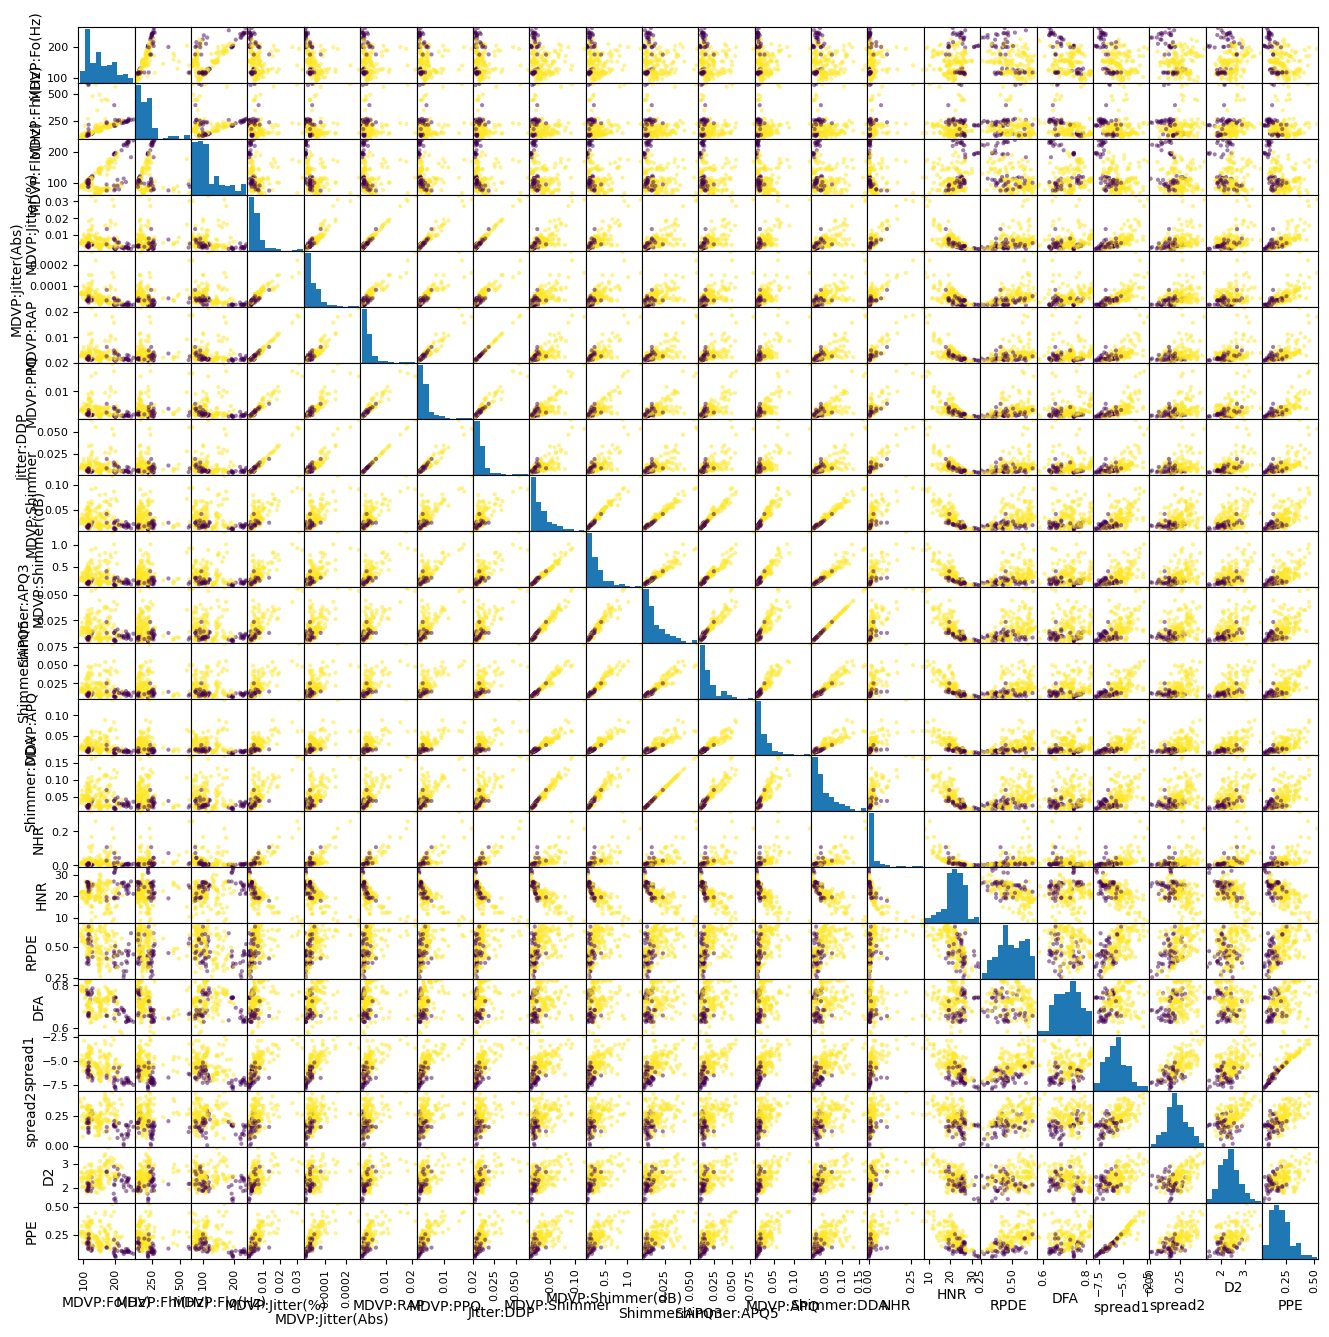

In [10]:
a = scatter_matrix(df2, figsize=(16, 16), c=y)

*Each attribute plotted against itself produces a distribution plot instead of a scatter plot* 

*Visually analyse and select pair combinations in which the two target groups are relatively distinct from each other rather than as a single line or overlapping points*

*These pairs will then be used in the further analysis* 

**Plotting each of the selected pair combinations to visualize the relationship more clearly**

<AxesSubplot:xlabel='PPE', ylabel='spread2'>

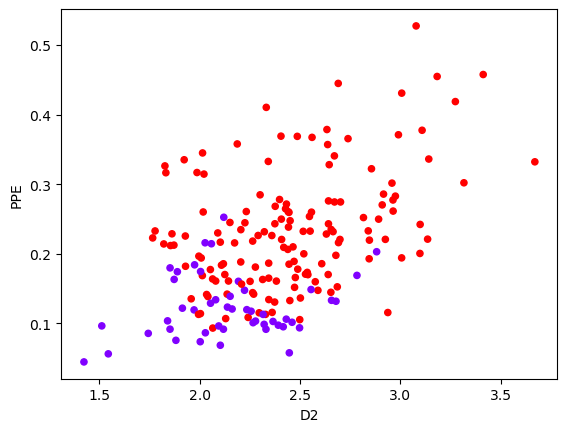

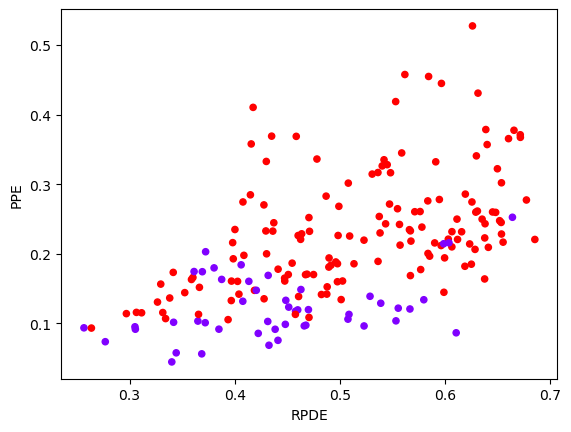

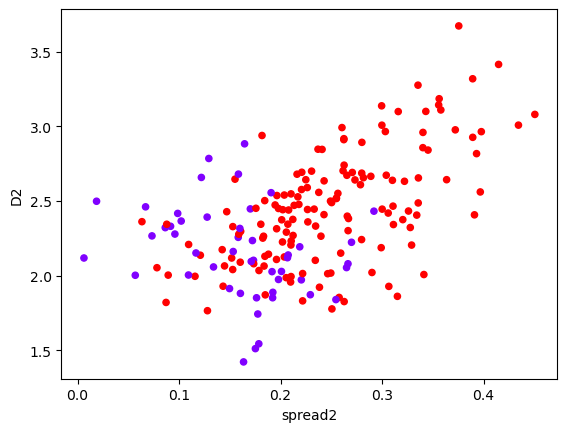

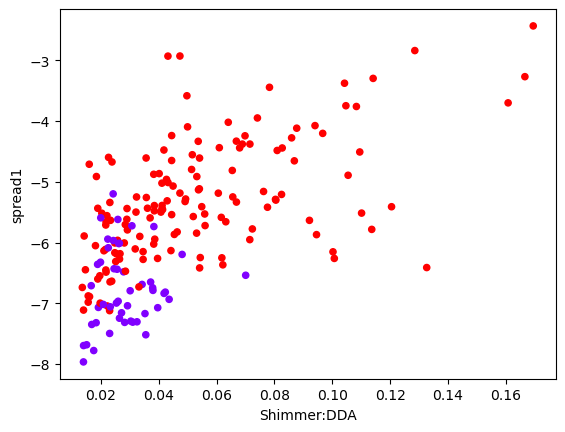

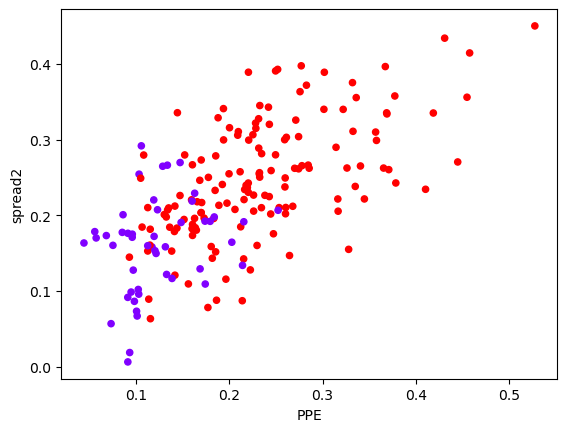

In [13]:
#D2 and PPE
df2.plot.scatter("D2", "PPE", c=y, colormap="rainbow", colorbar=False)
#RPDE and PPE
df2.plot.scatter("RPDE", "PPE", c=y, colormap="rainbow", colorbar=False)
#spread2 and D2
df2.plot.scatter("spread2", "D2", c=y, colormap="rainbow", colorbar=False)
#Shimmer:DDA and spread1
df2.plot.scatter("Shimmer:DDA", "spread1", c=y, colormap="rainbow", colorbar=False)
#PPE and spread2
df2.plot.scatter("PPE", "spread2", c=y, colormap="rainbow", colorbar=False)

**Normalizing the data for further analysis using scaling and viewing it as a dataframe**

In [14]:
scaler = StandardScaler()
scaler.fit(df2)
df2_scaled= scaler.transform(df2)
df3= pd.DataFrame(df2_scaled, columns=df2.columns)
df3

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,-0.829300,-0.436165,-0.952037,0.334914,0.749759,0.132963,0.760800,0.131755,0.745985,0.739536,...,0.332985,0.607532,-0.067893,-0.193225,-0.807838,1.760814,0.801323,0.480477,-0.210531,0.868886
1,-0.770972,-0.530974,-0.057721,0.715418,1.037674,0.453892,1.276809,0.452684,1.681731,1.768464,...,1.159454,1.548254,-0.137843,-0.634508,-0.387524,1.837562,1.479853,1.311185,0.275077,1.803605
2,-0.909476,-0.723168,-0.109875,0.884991,1.325589,0.720770,1.585687,0.721813,1.202693,1.027636,...,0.699187,1.175323,-0.291633,-0.279760,-0.662075,1.942048,1.141445,1.017682,-0.103629,1.402661
3,-0.909622,-0.649092,-0.114229,0.775389,1.325589,0.578885,1.284076,0.577677,1.340396,1.207698,...,0.806859,1.340229,-0.280719,-0.281346,-0.613134,1.832380,1.440945,1.293840,0.062145,1.806954
4,-0.925657,-0.606245,-0.130608,1.368893,1.901418,1.095750,2.047187,1.096793,1.836448,1.552389,...,1.216839,1.899461,-0.178026,-0.506745,-0.783021,1.909364,1.780940,0.096195,-0.130026,2.267082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,0.483467,0.371185,-0.508265,-0.337173,-0.401899,-0.228505,-0.311189,-0.227459,0.593395,0.631498,...,0.199282,0.759930,0.069278,-0.536647,-0.483208,-1.090704,-0.785527,-1.256837,0.721944,-0.817703
191,1.339202,0.612690,-0.618218,-0.120037,-0.401899,0.001213,-0.191272,0.002258,-0.116922,-0.099041,...,-0.313046,0.037108,-0.167360,-0.620463,-0.644916,-0.631503,-0.469859,-1.168475,1.054135,-0.418929
192,0.495578,0.470104,-0.968393,1.526058,1.037674,0.991026,0.797139,0.992069,-0.352453,-0.135053,...,-0.438466,-0.294679,2.041513,-0.906799,-0.877441,-1.130853,-1.014154,-0.818079,0.780338,-0.832410
193,1.078761,2.190044,-0.954180,0.243924,-0.113985,0.132963,0.164847,0.131755,-0.358834,-0.212223,...,-0.485202,-0.297970,1.175327,-0.649233,-0.456374,-1.343323,-0.974960,-0.229066,-0.637003,-0.926105


**Conducting further analysis on each of the chosen feature pair combinations**

**K-nearest neighbours analysis**

**1. D2 and PPE**

In [15]:
X = df3[["D2", "PPE"]] 
X

,D2,PPE
0,-0.210531,0.868886
1,0.275077,1.803605
2,-0.103629,1.402661
3,0.062145,1.806954
4,-0.130026,2.267082
...,...,...
190,0.721944,-0.817703
191,1.054135,-0.418929
192,0.780338,-0.832410
193,-0.637003,-0.926105


*Split our pair dataset (X) into a training and test dataset (at a roughly 80/20 split)*

*Hyperparametrising by setting the range of neighbours as 1-50 for the KNN analysis*

In [16]:
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)
parameters = {"n_neighbors" : range(1, 51),}
model = GridSearchCV(KNeighborsClassifier(), parameters)
model.fit(train_X, train_y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 51)})

*Plotting the mean test score and standard deviation for each value of K (number of neighbours)*

<AxesSubplot:xlabel='param_n_neighbors', ylabel='mean_test_score'>

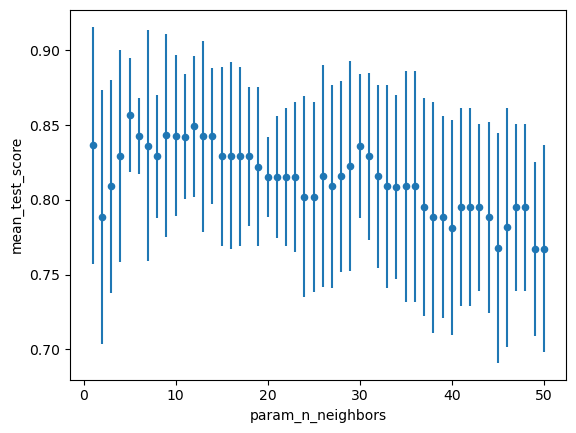

In [17]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score")

*Using the predefined plot_knn function to plot the results of the KNN analysis with the best k value* 

*The data points represent the existing data and the background colour represents the group that any hypoethetical data would be categorized into if added to those values*

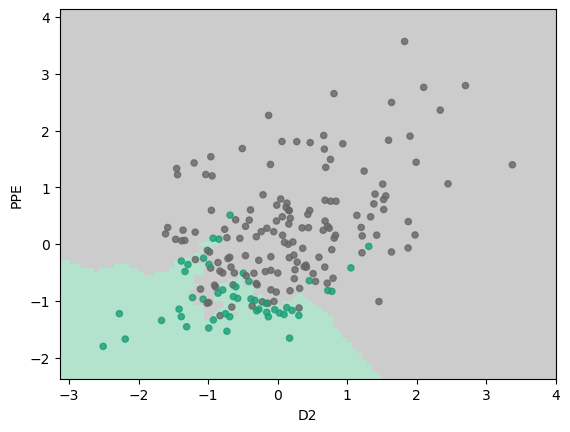

In [18]:
plot_knn(model, X, y)

*Getting a score of how well it scored against the test data set*

In [19]:
model.score(test_X, test_y)

0.8775510204081632

*Repeating all of the above for remaining pair combinations*

**2. RPDE and PPE**

0.9387755102040817

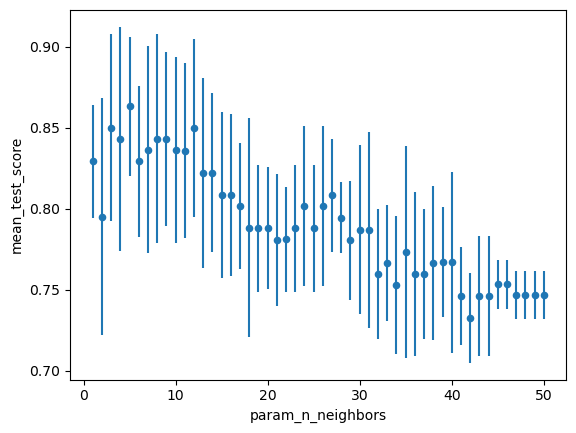

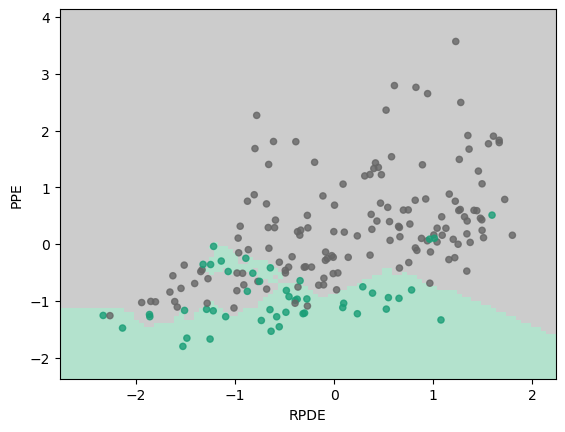

In [20]:
X = df3[["RPDE", "PPE"]] 
X

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)
parameters = {"n_neighbors" : range(1, 51),}
model = GridSearchCV(KNeighborsClassifier(), parameters)
model.fit(train_X, train_y)

cv_results = pd.DataFrame(model.cv_results_)
cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score")

plot_knn(model, X, y)

model.score(test_X, test_y)


**3. Spread2 and D2**

0.8163265306122449

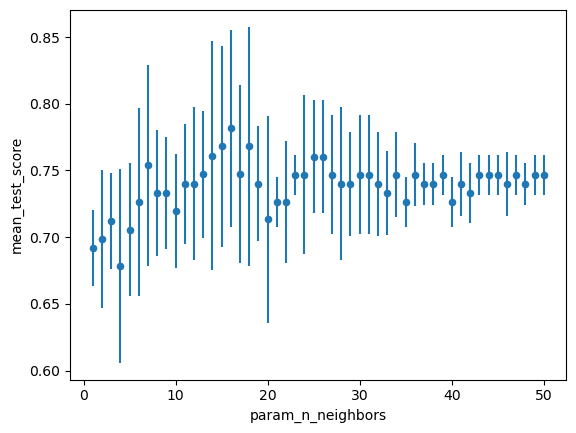

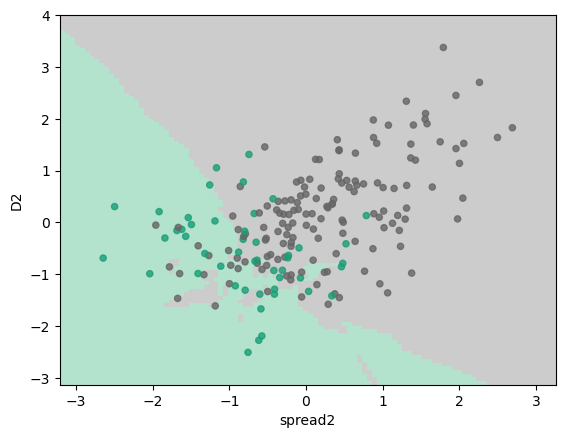

In [21]:
X = df3[["spread2", "D2"]] 
X

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)
parameters = {"n_neighbors" : range(1, 51),}
model = GridSearchCV(KNeighborsClassifier(), parameters)
model.fit(train_X, train_y)

cv_results = pd.DataFrame(model.cv_results_)
cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score")

plot_knn(model, X, y)

model.score(test_X, test_y)

**4. Shimmer:DDA and spread1**

0.9183673469387755

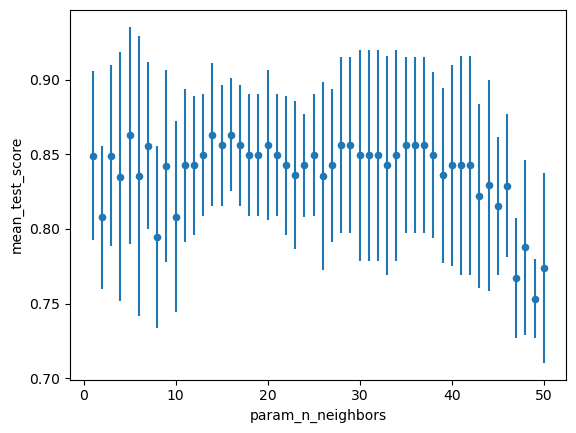

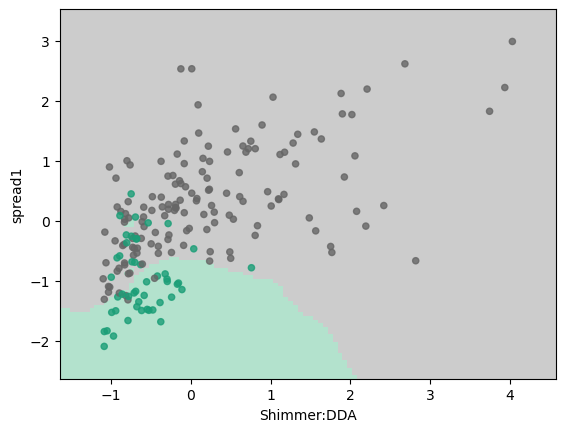

In [22]:
X = df3[["Shimmer:DDA", "spread1"]] 
X

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)
parameters = {"n_neighbors" : range(1, 51),}
model = GridSearchCV(KNeighborsClassifier(), parameters)
model.fit(train_X, train_y)

cv_results = pd.DataFrame(model.cv_results_)
cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score")

plot_knn(model, X, y)

model.score(test_X, test_y)

**5. PPE and spread2**

0.8979591836734694

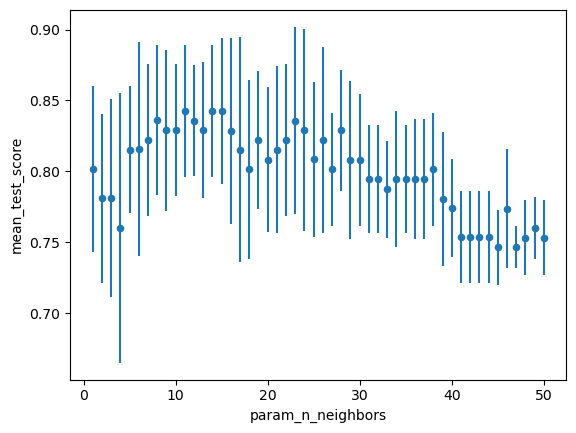

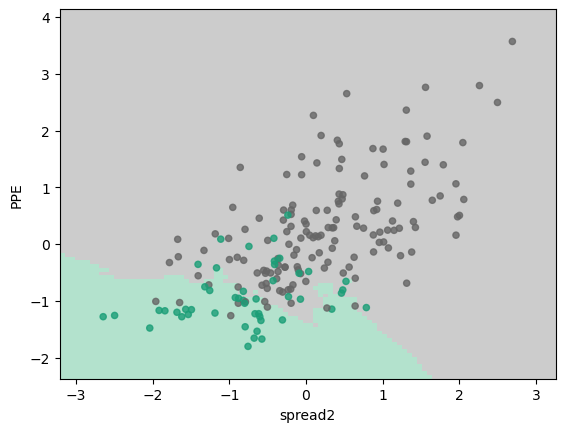

In [23]:
X = df3[["spread2", "PPE"]] 
X

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)
parameters = {"n_neighbors" : range(1, 51),}
model = GridSearchCV(KNeighborsClassifier(), parameters)
model.fit(train_X, train_y)

cv_results = pd.DataFrame(model.cv_results_)
cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score")

plot_knn(model, X, y)

model.score(test_X, test_y)

**Summary of model scores for each chosen measurement pair combination**

In [24]:
print('    Measurement pairs    Model Score')
print('D2 and PPE                  0.87755  ')
print('RPDE and PPE                0.93878  ')
print('spread2 and D2              0.81633  ')
print('Shimmer:DDA and spread1     0.91837  ')
print('PPE and spread2             0.89796  ')

    Measurement pairs    Model Score
D2 and PPE                  0.87755  
RPDE and PPE                0.93878  
spread2 and D2              0.81633  
Shimmer:DDA and spread1     0.91837  
PPE and spread2             0.89796  
